# Automated Extraction of 2D Seed Phenotype Data using a pre-trained `StarDist` model, `Scivision`, and `Pixelflow`

### This notebook demonstrates how to use pixelflow to extract measurements of segmented objects from 2D imagery. This demo will use 2D lightbox images of Oilseed rape (*Brassica napus*) seedpods detected and segmented using an adapted StarDist model as described in [Corcoran et al. 2023](https://www.frontiersin.org/articles/10.3389/fpls.2023.1120182/full).

### Example images required to run this notebook can be found [here](https://zenodo.org/records/8355920)

### R code used to run valve sorting in this notebook is available from the [Scivision gallery github page](https://github.com/scivision-gallery/pixelflow_seed_demo/tree/main) seed (`'seedpod_2D_valve_lowess_single.R'`)

## 1. Load dependencies including `Scivision` and `Pixelflow`

In [1]:
from pixelflow import pixelflow

import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread
from pathlib import Path

from glob import glob
import re

from scivision import default_catalog, load_pretrained_model

## 2. Find `StarDist Seed` model in `Scivision` model catalog

In [2]:
# load full scivision model catalog
models_catalog = default_catalog.models.to_dataframe()
models_catalog

,name,description,tasks,pkg_url,url,scivision_usable,institution,tags
0,stardist,Single class object detection and segementatio...,"(TaskEnum.object_detection, TaskEnum.segmentat...",git+https://github.com/stardist/stardist.git@m...,https://github.com/stardist/stardist,False,"(epfl,)","(2D, 3D, optical-microscopy, xray, microtomogr..."
1,PlantCV,Open-source image analysis software package ta...,"(TaskEnum.object_detection, TaskEnum.segmentat...",git+https://github.com/danforthcenter/plantcv@...,https://github.com/danforthcenter/plantcv,False,"(danforthcenter,)","(2D, hyperspectral, multispectral, near-infrar..."
2,greenotyper,Greenotyper is an image analysis tool for larg...,(TaskEnum.segmentation),git+https://github.com/MarniTausen/Greenotyper...,https://github.com/MarniTausen/Greenotyper,False,"(MarniTausen,)","(2D, multispectral, plant-phenotyping, climate..."
3,mapreader-plant,automated detection of plant patches in images...,"(TaskEnum.object_detection, TaskEnum.classific...",git+https://github.com/alan-turing-institute/m...,https://github.com/alan-turing-institute/mapre...,True,"(alan-turing-institute,)","(2D, plant, phenotype, rgb, biology, agriculture)"
4,resnet50-plankton,automated classification of plankton images co...,(TaskEnum.classificiation),git+https://github.com/alan-turing-institute/p...,https://github.com/alan-turing-institute/plank...,True,"(alan-turing-institute, cefas, plankton-analyt...","(2D, plankton, ecology, environmental-science)"
5,vedge-detector,automated detection of coastal vegetation edge...,(TaskEnum.segmentation),git+https://github.com/MartinSJRogers/VEdge_De...,https://github.com/MartinSJRogers/VEdge_Detect...,True,"(cambridge-university, birkbeck-university)","(2D, satellite, remote-sensing, ecology, envir..."
6,image-classifiers,Scivision plugin for the image-classifiers pac...,(TaskEnum.classificiation),git+https://github.com/alan-turing-institute/s...,https://github.com/alan-turing-institute/scivi...,True,"(alan-turing-institute,)","(classification, 2D, image)"
7,huggingface-classifiers,Selection of image classifiers taken from http...,(TaskEnum.classificiation),git+https://github.com/alan-turing-institute/s...,https://github.com/alan-turing-institute/scivi...,True,"(alan-turing-institute, huggingface)","(classification, 2D, image)"
8,huggingface-segmentation,Selection of segmentation algorithms taken fro...,(TaskEnum.segmentation),git+https://github.com/alan-turing-institute/s...,https://github.com/alan-turing-institute/scivi...,True,"(alan-turing-institute, huggingface)",()
9,huggingface-object-detection,Selection of object detection algorithms taken...,(TaskEnum.object_detection),git+https://github.com/alan-turing-institute/s...,https://github.com/alan-turing-institute/scivi...,True,"(alan-turing-institute, huggingface)",()


In [3]:
# get github repository link for the model we want to use (StarDist Seed)
model_repo = models_catalog[models_catalog.name == "StarDist Seed"].url.item()
model_repo

FlexibleUrl('https://raw.githubusercontent.com/alan-turing-institute/stardist-seed-pod/main/.scivision/model.yml', scheme='https', host='raw.githubusercontent.com', tld='com', host_type='domain', path='/alan-turing-institute/stardist-seed-pod/main/.scivision/model.yml')

## 3. Load `StarDist Seed` model from `Scivision` model catalog

In [4]:
# load pretrained seed model
model = load_pretrained_model(model_repo, model_selection= "model_2d", allow_install=True)
model

[11:59:50] INFO     Call='load_pretrained_model', module='scivision.io.reader', signature=(path:        ]8;id=735983;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/scivision/koala.py\koala.py]8;;\:]8;id=267354;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/scivision/koala.py#49\49]8;;\
                    os.PathLike, branch: str = 'main', allow_install: bool = False, model_selection:               
                    str = 'default', load_multiple: bool = False, *args, **kwargs) ->                              
                    scivision.io.wrapper.PretrainedModel, kwargs_given='model_selection, allow_install'            

2024-02-05 11:59:50.685966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 11:59:53.301841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.718646, nms_thresh=0.3.


scivision.PretrainedModel( 
  module='stardist_seed_pod', 
  model='model_2d', 
  source='https://github.com/alan-turing-institute/stardist-seed-pod' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

# Extract seed size and shape metrics from a single image (one seed pod) with `Pixelflow`

## 4. Load images

In [5]:
# load image
img = imread('01_Shengliyoucai_main_A.tif')
pod_name = '01_Shengliyoucai_main_A'

## 5. Predict location, size and shape of seeds with `StarDist Seed` model using `Scivision `core function

In [6]:
# detect and segment seeds in image
pred = model.predict(img)

In [7]:
# save seed labels created with Stardist Seed model
np.save(Path('content/' + pod_name + '_pred.npy'), pred)

## 6. Calculate seed size, shape and arrangement metrics with `Pixelflow`

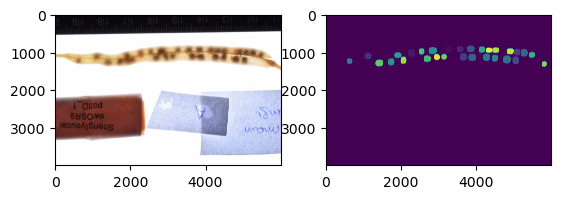

In [8]:
# load image and mask
img = imread('01_Shengliyoucai_main_A.tif')
mask = pred

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(mask)

In [9]:
# create table of size and shape metrics
features = pixelflow(
    mask,
    img,
    spacing=(0.03,0.03),
    features=('label', 'bbox', 'centroid', 'area', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity', 'image_intensity')
)

YX image detected


In [10]:
# show table of size and shape metrics in millimetres
features

,label,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,area,equivalent_diameter,major_axis_length,minor_axis_length,orientation,solidity
0,1,835,3742,1007,3946,27.659814,115.256195,26.5113,5.809926,6.408291,5.293776,-1.531574,0.991785
1,2,846,3470,1014,3652,27.888554,106.812965,23.2209,5.437441,5.688197,5.217015,1.524893,0.992079
2,3,859,3185,1023,3350,28.205184,98.013696,20.5407,5.114023,5.160864,5.084435,1.232456,0.991442
3,4,861,4054,1022,4221,28.218190,124.127465,20.5902,5.120181,5.244345,5.017989,-1.373028,0.992280
4,5,877,2725,1060,2948,29.050008,85.017869,30.9213,6.274569,6.983425,5.664964,-1.470105,0.992719
5,6,881,4416,1030,4600,28.647920,135.176317,20.8566,5.153198,5.761219,4.633875,-1.469292,0.991189
6,7,888,4241,1026,4417,28.731418,129.842832,18.3555,4.834351,5.516655,4.257249,-1.566841,0.989376
7,8,907,4796,1064,4988,29.551040,146.720336,23.0472,5.417066,5.982115,4.933751,-1.492895,0.991597
8,9,910,2463,1070,2615,29.664914,76.141714,18.5391,4.858468,5.006396,4.731858,-0.154559,0.991433
9,10,924,4993,1093,5161,30.250303,152.281324,21.5325,5.236032,5.288282,5.204249,0.673634,0.991710


In [11]:
# output csv with measurements
features.to_csv('01_Shengliyoucai_main_A.csv', header=True, index=False)

## 7. Save segmented images of each individual seed with `Pixelflow`

In [12]:
# make list of all seeds in mask, shift backwards by one to match index values
X = list(features.features.label)
for i in range(len(X)):
    X[i] -= 1

In [13]:
# save segmented images of all seeds within a seed pod
for file in X:
    np.save(pod_name + '_seed_' + str(features.features.label[file]) + '.npy', features.image_intensity[file])

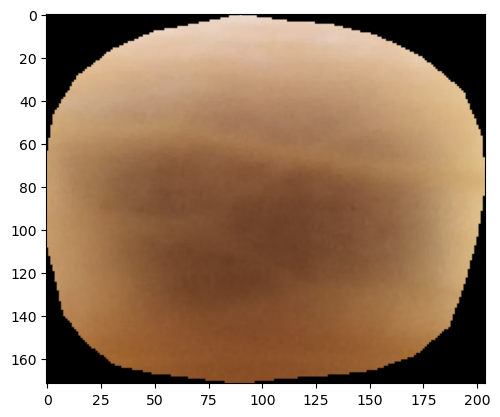

In [14]:
# load single seed image
seed_image = np.load('01_Shengliyoucai_main_A_seed_1.npy')

fig = plt.imshow(seed_image)

# Extract seed size and shape metrics and single seed images from multiple images (one seed pod per image) with `Pixelflow`

In [15]:
# load all input images
img_list = sorted(glob('content/*.tif'))
img_list

['content/DSC_0008.tif',
 'content/DSC_0017.tif',
 'content/DSC_0035.tif',
 'content/DSC_0039.tif']

In [16]:
for file in img_list:
  # load image and mask
  img = imread(file)
  pod_name = re.split("[/.]", file)[-2]
  pred = model.predict(img)
  np.save(Path('content/'+ pod_name + '_pred.npy'), pred)
  
  # create table of size and shape metrics
  features = pixelflow(
      mask=pred,
      image=img,
      spacing=(0.03,0.03),
      features=('label', 'bbox', 'centroid', 'area', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity', 'image_intensity'),
  )
  # output csv with measurements
  features.to_csv(pod_name + '.csv', header=True, index=False)

  # make list of all seeds in mask, shift backwards by one to match index values
  X = list(features.features.label)
  for i in range(len(X)):
      X[i] -= 1

  # save segmented images of all seeds within a seed pod
  for file in X:
      np.save(pod_name + '_seed_' + str(features.features.label[file]) + '.npy', features.image_intensity[file])

YX image detected
YX image detected
YX image detected
YX image detected


##  8. Sort detected seeds into 2 seeds pod valves, and calculated related measurements (order in valve from seed pod beak to pedicel, space between seeds in each valve) with `'seedpod_2D_valve_lowess_single.R'`

In [17]:
# import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects import conversion, default_converter
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

In [18]:
# R packages to install
with conversion.localconverter(default_converter):
  utils = rpackages.importr('utils')
  utils.chooseCRANmirror(ind=1)
  packnames = ('gplots', 'tidyverse')
  # Selectively install what needs to be install.
  names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
  if len(names_to_install) > 0:
      utils.install_packages(StrVector(names_to_install))

In [19]:
# Defining the R script and loading the instance in Python
r = robjects.r

In [20]:
for file in img_list:
  # Calculate the image data in pixelflow
  img2 = imread(file)
  pod_name = re.split("[/.]", file)[-2]
  mask2 = np.load(Path('content/'+ pod_name + '_pred.npy'))
  features2 = pixelflow(mask2, img2, features=('label', 'bbox', 'centroid', 'area', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity', 'image_intensity'))

  # Loading the function we have defined in R.
  with conversion.localconverter(default_converter):
      r['source']('seedpod_2D_valve_lowess_single.R')
      seedpod_2D_single_r = robjects.globalenv['seedpod_2D_single']

  #converting dataframe into r object for passing into r function
  with (robjects.default_converter + pandas2ri.converter).context():
    r_from_pd_df = robjects.conversion.get_conversion().py2rpy(features2.features)

  #Invoking the R function and getting the result
  with conversion.localconverter(default_converter):
      df_result_r = seedpod_2D_single_r(r_from_pd_df, "plot_" + pod_name + ".png")

  #Converting it back to a pandas dataframe
  with (robjects.default_converter + pandas2ri.converter).context():
    df_result = robjects.conversion.get_conversion().rpy2py(df_result_r)


YX image detected
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[12:00:54] WARNING  R[write to console]:                                                           ]8;id=899543;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=481582;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                    Attaching package: ‘gplots’                                                                    
                                                                                                                   
                                                                                                                   

           WARNING  R[write to console]: The following object is masked from ‘package:stats’:      ]8;id=305299;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=632937;file:///Users/ifenton/opt/anaconda3/envs/test_pxsd4/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                                                                                                                   
                        lowess                                                                                     
                                                                                                                   
                                                                                                                   

YX image detected
YX image detected
YX image detected
